# Machine Learning Nanodegree - Capstone Project
### Starbuck Awards Program Analysis
The problem statement is to predict wheter customer will accept to an offer from given demographics informations and type of campaign (BOGO, discount etc.).

**The problem will be Binary Classification** <br/>
Postive class : customer accept the offer (1) <br/>
Negative class : customer do not accept the offer (0)

In [56]:
import pandas as pd
import numpy as np
import json
import math

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import LabelEncoder


!jt -t onedork

In [57]:
portfolio = pd.read_json('Dataset/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('Dataset/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('Dataset/transcript.json', orient = 'records', lines = True)

# Data Preparation
## Portfolio
Portfolio dataset contain informations about campaign informations that sent customers.

In [58]:
print(f'Portfolio have {portfolio.shape[0]} rows and {portfolio.shape[1]} columns')
portfolio

Portfolio have 10 rows and 6 columns


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### Data Cleaning

1. Split the `channel` column in to 4 columns for further data modelling.<br/>
*Email, Mobile, Social, Web*
2. Perform one-hot encoder for `offer_type`

In [59]:
# Create onehot columns for channels by extract string and joining with | symbols
channel_onehot = portfolio['channels'].str.join('|').str.get_dummies().add_prefix('channel_')

# Join channel_onehot into main dataset and drop the origial channels column
portfolio = portfolio.join(channel_onehot)
portfolio.drop(['channels'], axis = 1, inplace = True)

# Transform offer_type into one-hot columns
portfolio = portfolio.join(pd.get_dummies(portfolio.pop('offer_type')).add_prefix('offer_type_'))

# Rename columns 
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)


In [60]:
portfolio.sample(10)

,reward,difficulty,duration,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0


## Profile
Profile dataset contain demographic information for each customer on rewards program.

In [61]:
print(f'Profile have {profile.shape[0]} rows and {profile.shape[1]} columns')
profile.head(10)

Profile have 17000 rows and 5 columns


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


On profile dataset, we do not have any duplicate customer_id. Total customer_id is 17,000 users

In [62]:
print('Number of unique customer id ', len(profile['id'].unique()))

Number of unique customer id  17000


### Data Cleaning

Convert `became_member_on` to datetime format. <br/>
Create `became_member_on_long` as how long user became member compare with current date<br/>
Exract `year` and `month` of becoming the member on reward application

In [63]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['became_member_on_long'] = (pd.to_datetime('today') - pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')).astype('timedelta64[D]').astype(int)

profile['start_year'] = profile.became_member_on.dt.year
profile['start_month'] = profile.became_member_on.dt.month

In [64]:
profile.drop('became_member_on', axis = 1, inplace = True)
profile.sort_values('became_member_on_long', ascending = False)

,gender,age,id,income,became_member_on_long,start_year,start_month
8948,M,64,77388a70eaf14433b4efc5d01fa947bf,69000.0,2526,2013,7
569,M,36,dbb4766b7dd94ca2b83a855312a3ebe9,74000.0,2525,2013,7
1200,M,52,5ffdab087e674149a89324a732b4f993,65000.0,2525,2013,7
7796,F,58,d25f38519a89455499c9e49e67ae1511,55000.0,2525,2013,7
10933,F,67,7b42b5bbe237406aaf2748a09050f745,58000.0,2524,2013,7
...,...,...,...,...,...,...,...
12560,F,49,464738f7360847adb55de84c859ba8af,50000.0,703,2018,7
10282,M,46,e4989ca3d8974e28a3fe87aa0b0ce327,74000.0,703,2018,7
8152,F,48,fb75504a0e404549995a3e8427a2a252,64000.0,703,2018,7
1517,M,28,267e47de94fd46b1afa96dea1c9d3cbf,33000.0,703,2018,7


#### Check missing value
Find out that `Gender` and `Income` have missing on the same positions with some reason.

In [65]:
profile.isna().mean()*100

gender                   12.794118
age                       0.000000
id                        0.000000
income                   12.794118
became_member_on_long     0.000000
start_year                0.000000
start_month               0.000000
dtype: float64

Visually check the missing data in form of matrix by sort age.
- Found that all missing value of `income` and `gender` occur together.
- `age` for these missing value is all same value 118 <br/>
From these findings and amount of missing data, all NaN will be dropped.

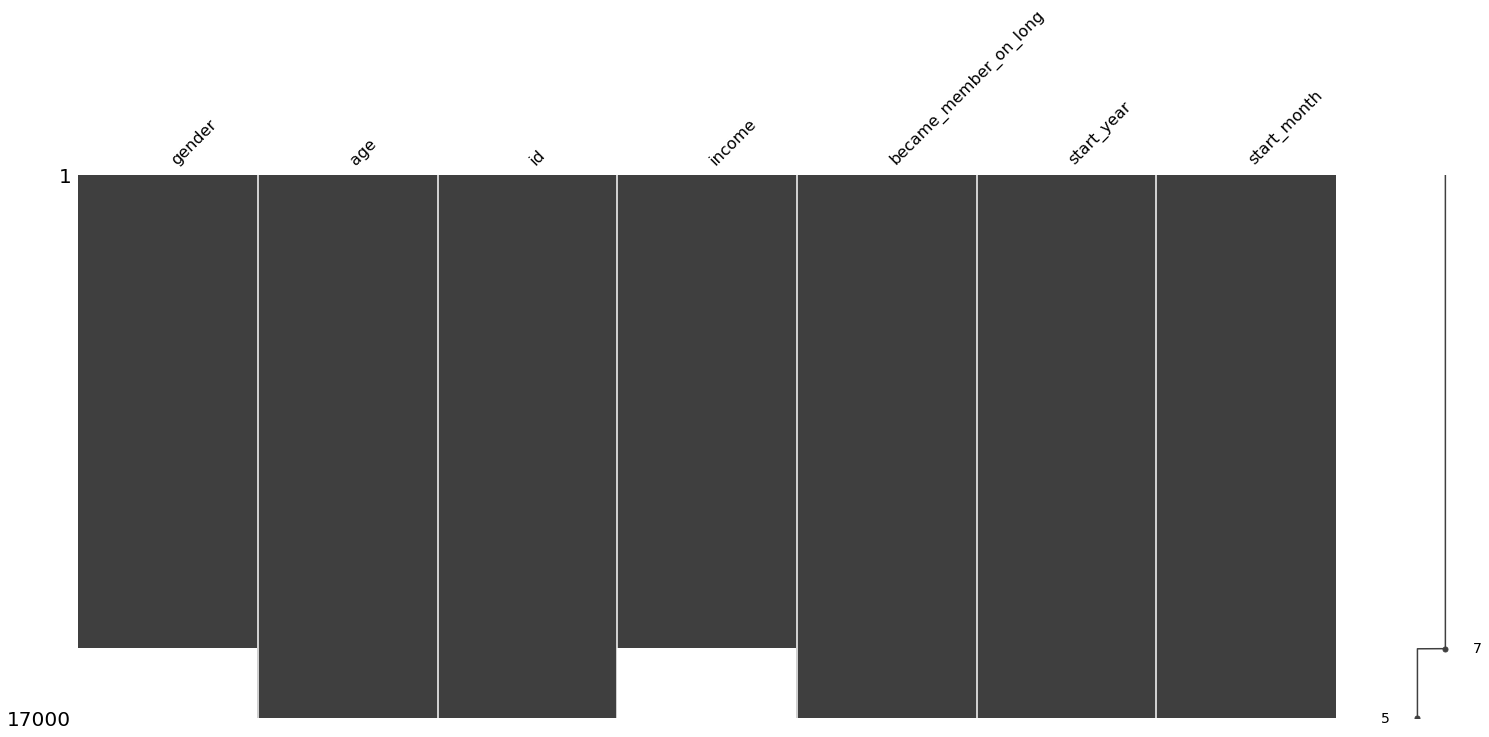

In [66]:
%matplotlib inline
msno.matrix(profile.sort_values(by = 'age'))

In [67]:
profile[profile['age'] == 118].sample(10)

,gender,age,id,income,became_member_on_long,start_year,start_month
16660,None,118,5e78586d062041f1bfe97eacc63e1485,NaN,907,2018,1
12021,None,118,a99417934b694273bb5991d6897ee1f8,NaN,1779,2015,8
9720,None,118,71d9a96b20854903a5a393415ca43c6a,NaN,928,2017,12
7083,None,118,05f7979ead604ba1947685f603023b1e,NaN,1479,2016,6
3666,None,118,12da1e886d0c405299369ee3f0d975e1,NaN,864,2018,2
9190,None,118,0100dbd4e8554aa69b73b6ac0547f6bf,NaN,913,2017,12
10857,None,118,659205cbe3a848e3a18e4ff1c65e5f91,NaN,1662,2015,12
4432,None,118,c33c236fec0c4a3ba91389f33c7b7547,NaN,1556,2016,3
2437,None,118,18b4fdca88b347aa8a7d8ffec773eaeb,NaN,961,2017,11
7009,None,118,dfebfdd6cb024279b1f8844476a789d5,NaN,979,2017,10


In [68]:
# Drop na in any positions
profile.dropna(how = 'any', axis = 0 ,inplace = True)

# Check amount of missing value after delete NaN in dataframe
profile.isna().mean()*100

gender                   0.0
age                      0.0
id                       0.0
income                   0.0
became_member_on_long    0.0
start_year               0.0
start_month              0.0
dtype: float64

Create new column 'loyalty_type' base on duration of becoming member. <br/>
*new*, *regular*, *loyalty*

In [69]:
profile['loyalty_type'] = pd.cut(profile['became_member_on_long'], 
                                  bins = [350, 1000,
                                          1700, 2600],
                                  labels = ['new', 'regular', 'loyalty']).astype(str)
profile.drop('became_member_on_long', axis = 1, inplace = True)
profile['loyalty_type'].value_counts()

regular    6810
new        5941
loyalty    2074
Name: loyalty_type, dtype: int64

Create new column 'income' base on duration of becoming member. <br/>
*medium*, *above-medium*, *high*

In [70]:
# Create income_grougp as a categorical of income
profile['income_group'] = pd.cut(profile['income'], 
                                    bins=[28000, 60000, 90000, 130000],
                                    labels=['medium', 'above-medium', 'high']).astype(str)

profile.drop('income', axis = 1, inplace = True)
profile['income_group'].value_counts()

medium          6693
above-medium    5938
high            2194
Name: income_group, dtype: int64

In [71]:
# Create age_group as a categorical of age
profile['age_group'] = pd.cut(profile['age'], 
                                    bins=[15, 23, 40, 65, 105],
                                    labels=['teen', 'young-adult', 'adult', 'elderly']).astype(str)

profile.drop('age', axis = 1, inplace = True)
profile['age_group'].value_counts()

adult          7537
elderly        3986
young-adult    2565
teen            737
Name: age_group, dtype: int64

Perform label encoder on `gender`, `age_group` and `loyalty_type`columns

In [72]:
# Use label endcoder on all new generated categorical columns
le = LabelEncoder()

profile['gender'] = le.fit_transform(profile['gender'])
profile['age_group'] = le.fit_transform(profile['age_group'])
profile['loyalty_type'] = le.fit_transform(profile['loyalty_type'])
profile['income_group'] = le.fit_transform(profile['income_group'])

In [73]:
profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [76]:
profile.sample(10)

,gender,customer_id,start_year,start_month,loyalty_type,income_group,age_group
14786,1,0fa86ae026dc4ed3a9ec0f4676239e9d,2018,5,1,0,0
2046,1,a3231d1a8afa4e06acd0eaa84acf7c0d,2018,7,1,1,0
917,0,776776cd1717444c89dc11101ae4a21f,2018,4,1,2,0
4500,2,cd4fa4f3a829491aa189480ad2d06940,2017,11,1,1,0
15436,0,a7462c7c3d3c4aa5b6f8c906394d85c7,2017,12,1,0,0
4448,0,a24c2ccbffcb47d29491771856b1dcd3,2016,9,2,2,1
15200,1,ce9f0e99023449349daeb36e40801552,2015,8,0,1,1
1348,0,2d5b8dfaa968465b89949bc63fd0cf6b,2015,8,0,1,0
12978,1,f66fac9c993d4717802a635c7a34a852,2017,12,1,0,2
13719,1,07adfad3f0c54e738d60fd5a51285486,2018,7,1,2,0


In [19]:
# customer_id_list = profile['customer_id'].astype('category').cat.categories.tolist()
# customer_id_list_number = {'customer_id' : {k: v for k,v in zip(customer_id_list,list(range(1,len(customer_id_list)+1)))}}

# profile.replace(replace_map_comp_customer_id, inplace = True)

## Transcript

In [78]:
print(f'Portfolio have {transcript.shape[0]} rows and {transcript.shape[1]} columns')
transcript

Portfolio have 306534 rows and 4 columns


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [79]:
# Transform and extract amount, offer_id, reward from value columns
transcript_value_df = pd.DataFrame.from_records(transcript.pop('value'))
transcript = transcript.join(transcript_value_df)
transcript.offer_id.update(transcript.pop('offer id'))

#### Select Event for Binary Classification
Since, we are interested in event that customer response to offer campaign.<br/>
- 'transaction' will be excluded out from the data frame
-  `offer_received` and `offer_viewed` will be classified as `offer_not_completed`

In [83]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [85]:
# Exclude event = 'transaction' from dataset
transcript = transcript[transcript['event'] != 'transaction']

# Replace 'offer_received' and 'offer_viewd' as 'offer_not_completed'
transcript['event'].replace({'offer received':'offer not completed', 'offer viewed':'offer completed'}, inplace = True)

/Users/wasuratsoontronchai/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [86]:
transcript.event.value_counts()

offer completed        91304
offer not completed    76277
Name: event, dtype: int64

In [87]:
# Perform one-hot encoder on event column
transcript = transcript.join(pd.get_dummies(transcript.pop('event')).add_prefix('event_'))

In [88]:
# Rename column
transcript.rename(columns = {'person':'customer_id'}, inplace = True)

In [89]:
transcript

,customer_id,time,amount,offer_id,reward,event_offer completed,event_offer not completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1
...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,0
306506,b895c57e8cd047a8872ce02aa54759d6,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0
306509,8431c16f8e1d440880db371a68f82dd0,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0


In [26]:
transcript[transcript['customer_id'] == 'b3a1272bc9904337b331bf348c3e8c17']

,customer_id,time,amount,offer_id,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
12619,b3a1272bc9904337b331bf348c3e8c17,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
31105,b3a1272bc9904337b331bf348c3e8c17,48,4.02,NaN,NaN,0,0,0,1
36911,b3a1272bc9904337b331bf348c3e8c17,72,2.22,NaN,NaN,0,0,0,1
49498,b3a1272bc9904337b331bf348c3e8c17,138,3.94,NaN,NaN,0,0,0,1
101457,b3a1272bc9904337b331bf348c3e8c17,276,2.14,NaN,NaN,0,0,0,1
148924,b3a1272bc9904337b331bf348c3e8c17,396,6.71,NaN,NaN,0,0,0,1
163340,b3a1272bc9904337b331bf348c3e8c17,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,1,0,0
171199,b3a1272bc9904337b331bf348c3e8c17,414,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,0,1,0
171200,b3a1272bc9904337b331bf348c3e8c17,414,0.77,NaN,NaN,0,0,0,1
177255,b3a1272bc9904337b331bf348c3e8c17,426,7.12,NaN,NaN,0,0,0,1


In [29]:
profile[profile['customer_id'] == 'b3a1272bc9904337b331bf348c3e8c17']

,gender,customer_id,income,became_member_on_long,start_year,start_month,age_group
16959,1,b3a1272bc9904337b331bf348c3e8c17,47000.0,908,2018,1,1


In [27]:
transcript[transcript['customer_id'] == 'e2127556f4f64592b11af22de27a7932']

,customer_id,time,amount,offer_id,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
20283,e2127556f4f64592b11af22de27a7932,18,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,0,1,0
102635,e2127556f4f64592b11af22de27a7932,288,17.88,NaN,NaN,0,0,0,1
103834,e2127556f4f64592b11af22de27a7932,294,21.43,NaN,NaN,0,0,0,1
110830,e2127556f4f64592b11af22de27a7932,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
150600,e2127556f4f64592b11af22de27a7932,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
171209,e2127556f4f64592b11af22de27a7932,420,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0
201574,e2127556f4f64592b11af22de27a7932,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
225059,e2127556f4f64592b11af22de27a7932,522,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,0,1,0
225060,e2127556f4f64592b11af22de27a7932,522,18.42,NaN,NaN,0,0,0,1
